In [1]:
import pandas as pd
import scipy.io as io
import numpy as np
import scanpy as scp
import seaborn as sns
import matplotlib.pyplot as plt

from parameters import *

import sys
sys.path.append('../../')
import single_cell_tools.tools as scttools
import single_cell_tools.plot as sctplot

In [2]:
d = pd.read_csv("GSE150412_RawCounts.csv")
d.fillna(0,inplace=True)
var = d[["gene_id","gene_name"]]
X = d.iloc[:,3:].transpose()

In [3]:
accessors = pd.read_csv("GSE150412-GPL19057_series_matrix.txt",sep="\n",header=None)
obs = pd.DataFrame()
obs.loc[:,"Accessor"] = accessors.iloc[18,0].split(" ")[1:1289]
obs.loc[:,"Sample"] = [i[1:-1] for i in accessors.iloc[34,0].split("\t")[1:]]
obs.loc[:,"Genotype"] = [i[11:-1] for i in accessors.iloc[45,0].split("\t")[1:]]
obs.loc[:,"Cell"] = [i.split("_E")[0] for i in obs["Sample"].values]
obs.loc[:,"Stage"] = [i.split("_")[2] for i in obs["Sample"].values]
obs.loc[obs.loc[:,"Stage"]=="FE10.5","Stage"] = "E10.5"
obs.loc[:,"Sorted"] = [i.split("-")[1] for i in obs["Sample"].values]

In [4]:
obs = obs.astype(str)

In [5]:
adata = scp.AnnData(X)
adata.obs = obs
adata.var = var
adata.layers["Raw"] = X.copy()

# QC

In [6]:
mtgenes = ["mt-" in i for i in adata.var["gene_name"]]
scttools.qc_metrics(adata,mtgenes)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


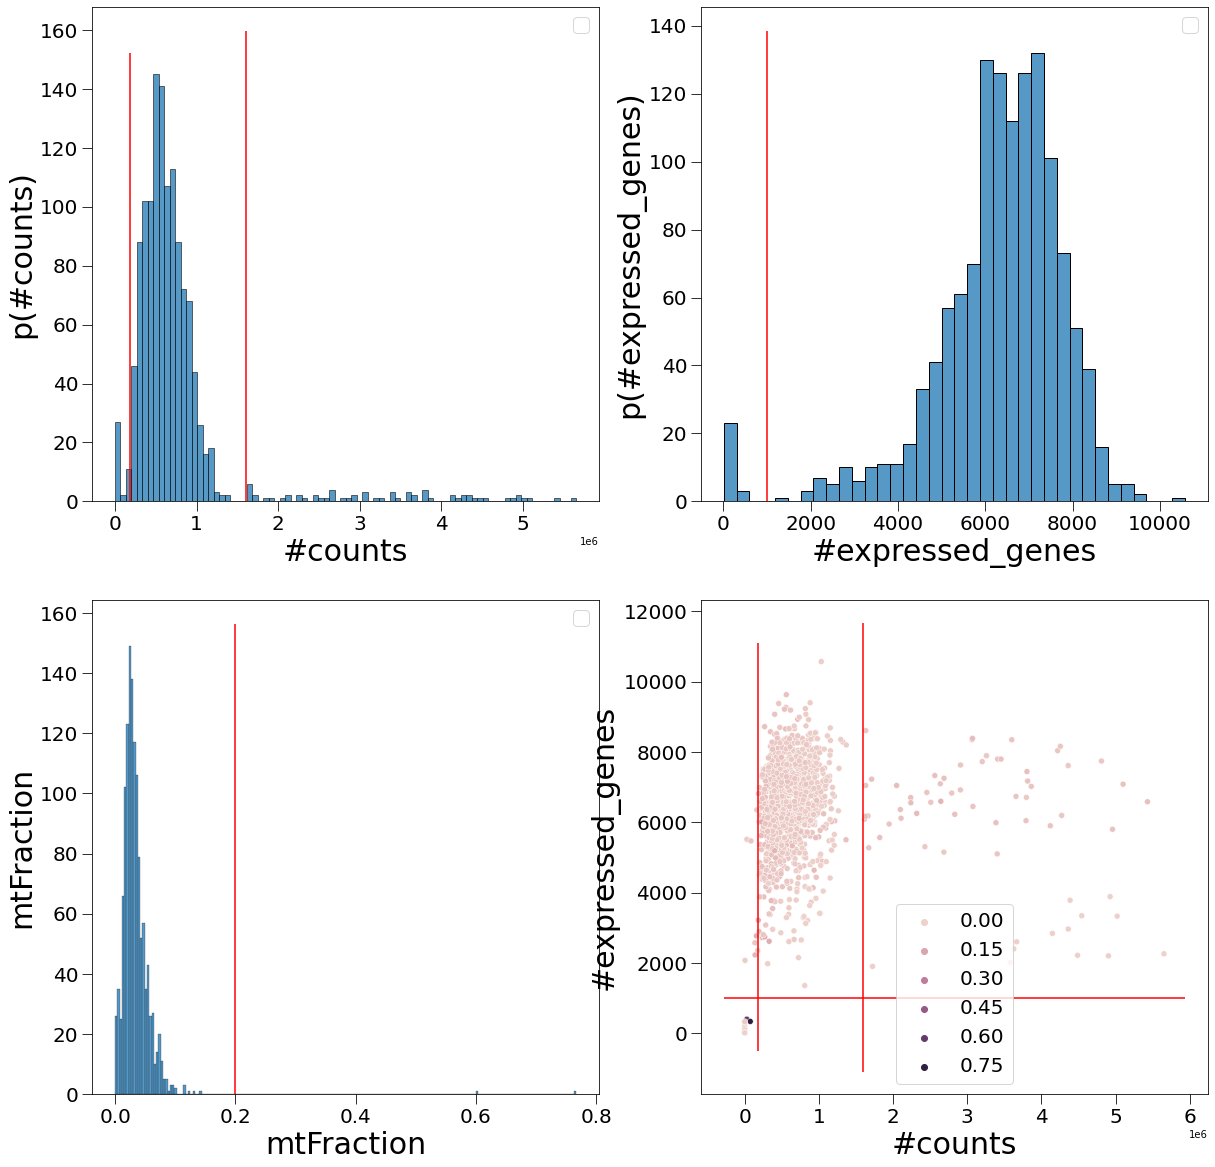

In [7]:
fig,ax = plt.subplots(2,2,figsize=[20,20])

sns.histplot(data=adata.obs,x="#counts",ax=ax[0,0])
sctplot.plot_base(ax[0,0],labels=["#counts","p(#counts)"])
sctplot.vline(ax[0,0],COUNTS_MIN,color="r")
sctplot.vline(ax[0,0],COUNTS_MAX,color="r")

sns.histplot(data=adata.obs,x="#expressed_genes",ax=ax[0,1])
sctplot.plot_base(ax[0,1],labels=["#expressed_genes","p(#expressed_genes)"])
sctplot.vline(ax[0,1],GENES_MIN,color="r")

sns.histplot(data=adata.obs,x="mtFraction",ax=ax[1,0])
sctplot.plot_base(ax[1,0],labels=["mtFraction","mtFraction"])
sctplot.vline(ax[1,0],MTFRACTION_MAX,color="r")

sns.scatterplot(data=adata.obs,y="#expressed_genes",x="#counts",hue="mtFraction",ax=ax[1,1])
sctplot.plot_base(ax[1,1],labels=["#counts","#expressed_genes"])
sctplot.hline(ax[1,1],GENES_MIN,color="r")
sctplot.vline(ax[1,1],COUNTS_MIN,color="r")
sctplot.vline(ax[1,1],COUNTS_MAX,color="r")

fig.show()

In [8]:
retained, summary = scttools.filter_cells(adata,
            ("#counts",COUNTS_MIN,COUNTS_MAX),
            ("#expressed_genes",GENES_MIN,np.Inf),
            ("mtFraction",0,MTFRACTION_MAX)) #originally we kept empty as well

summary

,Object,#below,%below,#above,%above,Total_removed,%Total_removed
0,obs.#counts,34,0.026398,65,0.050466,99,0.076863
1,obs.#expressed_genes,26,0.020186,0,0.0,26,0.020186
2,obs.mtFraction,0,0.0,2,0.001553,2,0.001553
3,TOTAL_,0,0,0,0,99,0.076863


In [9]:
retained

array([False,  True, False, ...,  True,  True,  True])

# Fig 1: All data except Mes and Runx1

In [10]:
subset = np.array([("Mes" not in i) and ("Runx1" not in i) for i in adata.obs["Sorted"].astype(str).values])
adata1 = adata[subset*retained]
adata1.layers["raw"] = adata1.X.copy()

In [11]:
adata.obs["Sorted"].unique()

array(['HE_Gfi1_het', 'Endo_Gfi1_het', 'IAHC_het', 'EHT_het',
       'HE_Gfi1_1b_KO', 'HE_Runx1_het', 'Mes_het', 'Mes_KO',
       'HE_Runx1_KO', 'Endo_Runx1_het'], dtype=object)

In [12]:
adata1.obs["Sorted"].unique()

array(['HE_Gfi1_het', 'IAHC_het', 'Endo_Gfi1_het', 'EHT_het',
       'HE_Gfi1_1b_KO'], dtype=object)

In [13]:
scp.pp.normalize_total(adata1,target_sum=100000)
scp.pp.log1p(adata1)
scp.pp.highly_variable_genes(adata1)
scp.pp.pca(adata1,n_comps=20)
scp.pp.neighbors(adata1,metric="correlation",knn=15)
scp.tl.umap(adata1)

2022-08-13 16:31:37.570672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-13 16:31:37.570688: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


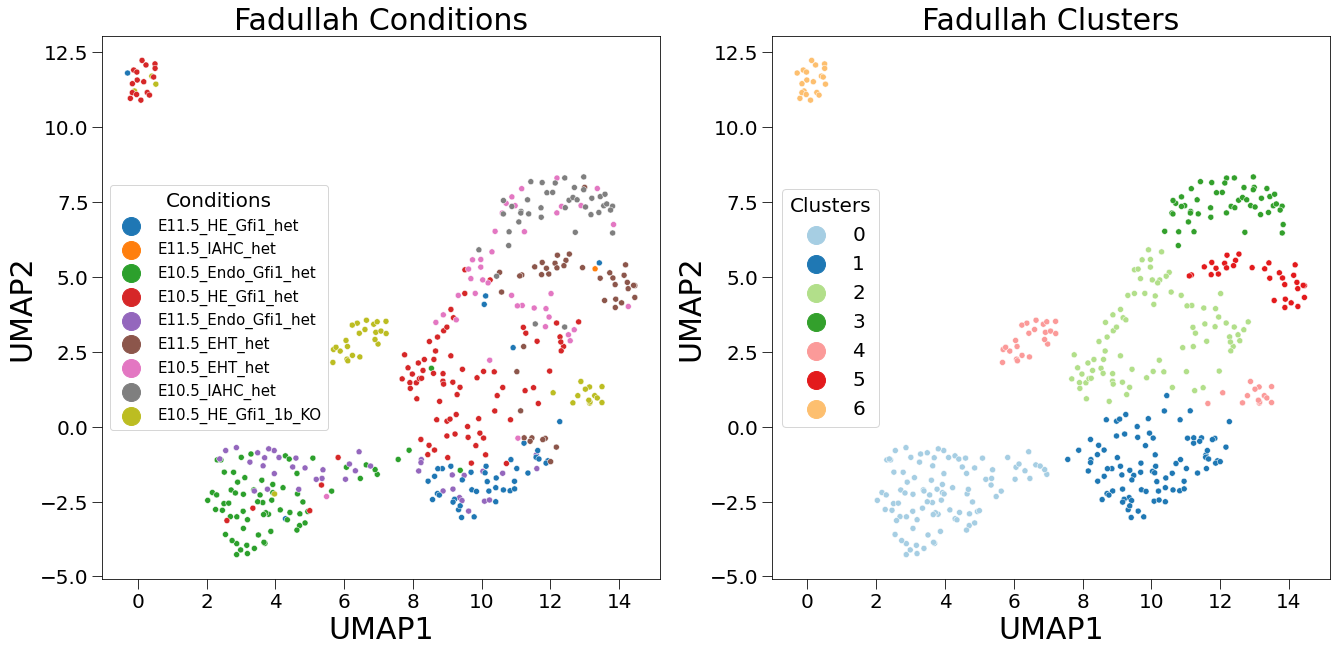

In [14]:
fig,ax = plt.subplots(1,2,figsize=[22,10])

scp.tl.leiden(adata1,resolution=.5)

X = adata1.obsm["X_umap"]
hue = [i+"_"+j for i,j in adata1.obs[["Stage","Sorted"]].values]
sns.scatterplot(x=X[:,0],y=X[:,1],hue=hue,ax=ax[0])
sctplot.plot_base(ax[0],labels=["UMAP1","UMAP2"],title="Fadullah Conditions",legend_title="Conditions",legend_size=15,legend_markerscale=3)

X = adata1.obsm["X_umap"]
hue = adata1.obs["leiden"].values
sns.scatterplot(x=X[:,0],y=X[:,1],hue=hue,ax=ax[1],palette="Paired")
sctplot.plot_base(ax[1],labels=["UMAP1","UMAP2"],title="Fadullah Clusters",legend_title="Clusters",legend_size=20,legend_markerscale=3)

fig.savefig("Plots/Fadlullah1_umaps.pdf",bbox_inches="tight",transparent=True)
plt.show()

In [15]:
adata1.write("Fadlullah1.h5ad")

... storing 'Genotype' as categorical
... storing 'Stage' as categorical
... storing 'Sorted' as categorical
... storing 'gene_name' as categorical


## DE

In [16]:
scp.tl.rank_genes_groups(adata1,groupby="leiden",method="wilcoxon",use_raw=False)
scttools.rank_genes_to_excel(adata1,"gene_name","Tables/Fadullah1_annotation.xlsx",2000)

## Enrichr

In [17]:
ENRICHR_LIBRARIES = ["Descartes_Cell_Types_and_Tissue_2021","PanglaoDB_Augmented_2021"]

In [18]:
for library in ENRICHR_LIBRARIES:
    scttools.enrichr_to_excel(adata1,library,"Tables/Fadullah1_Enrich_"+library+".xlsx")

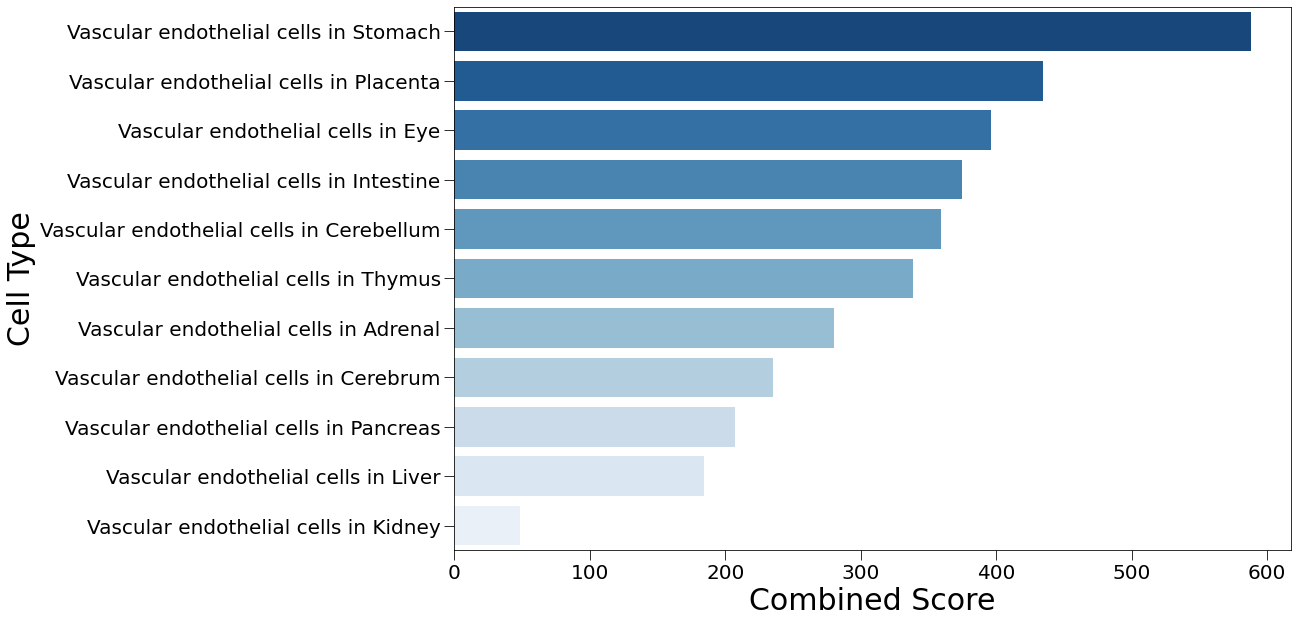

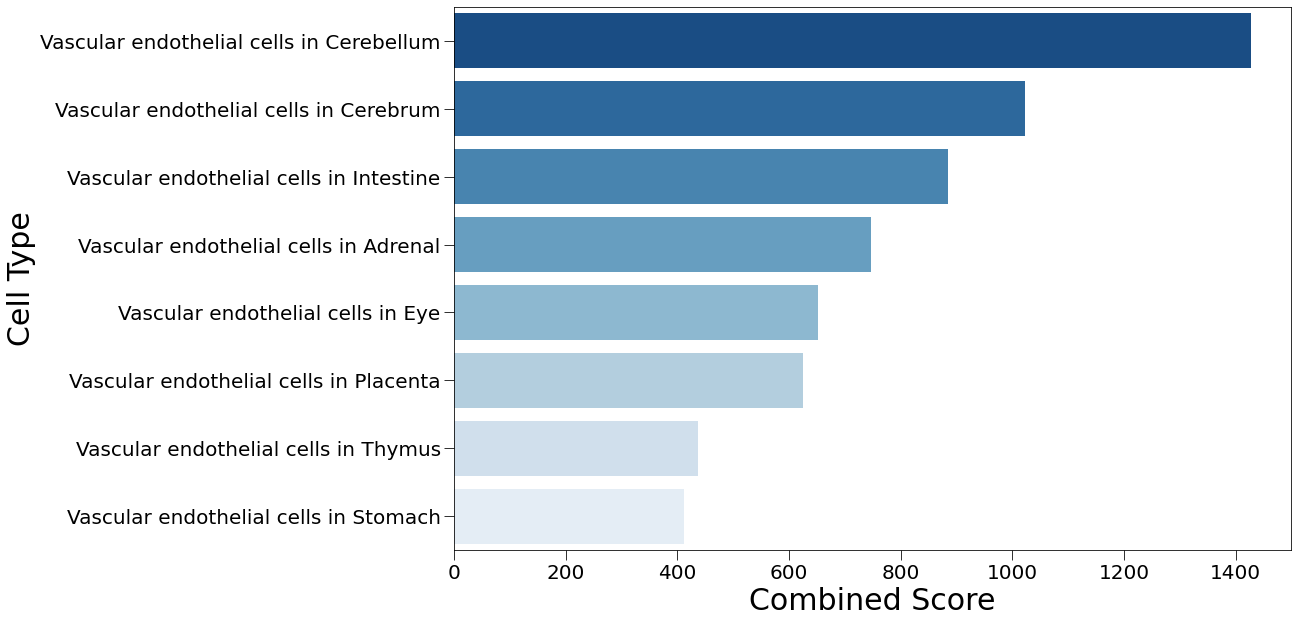

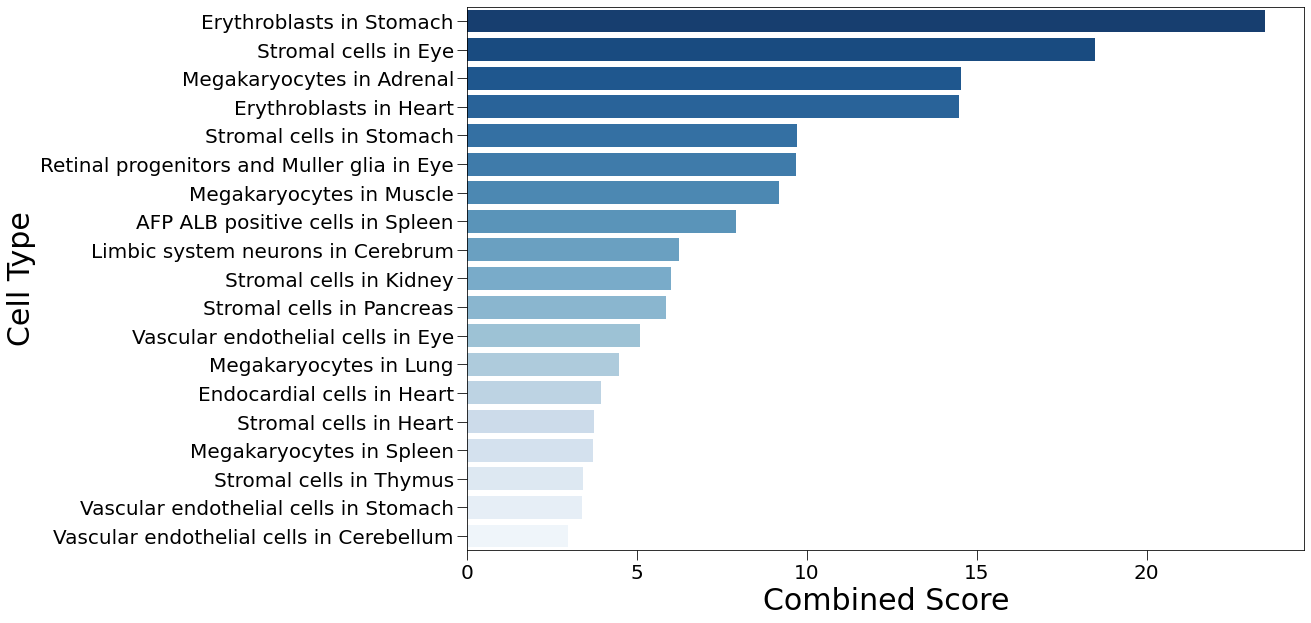

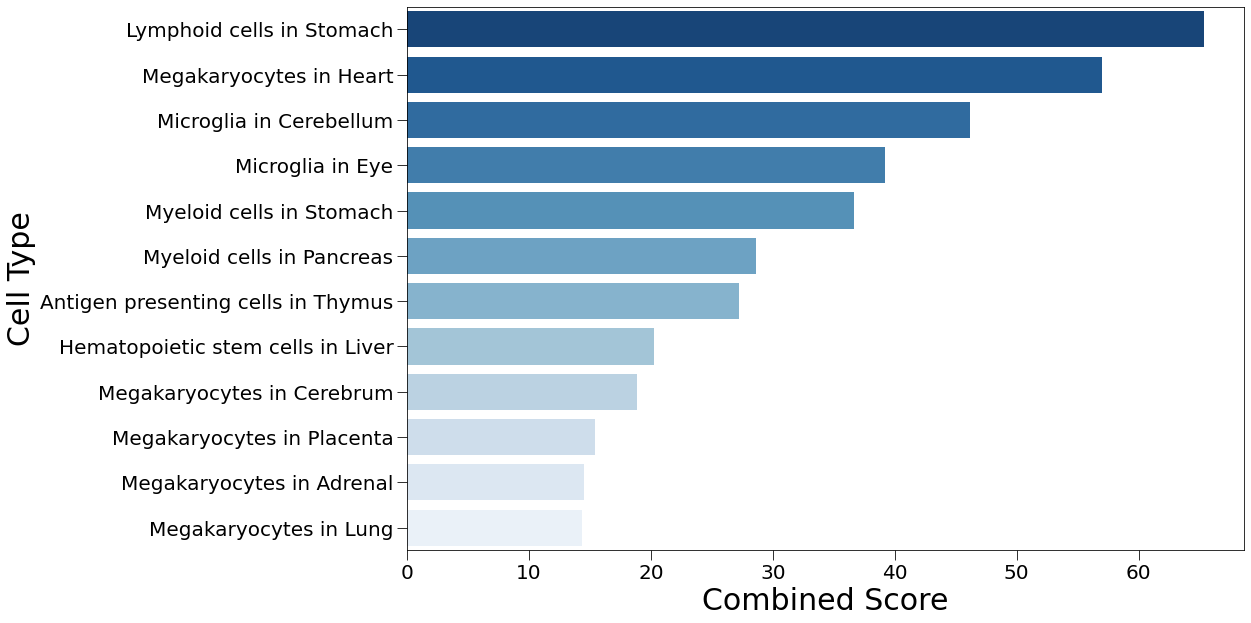

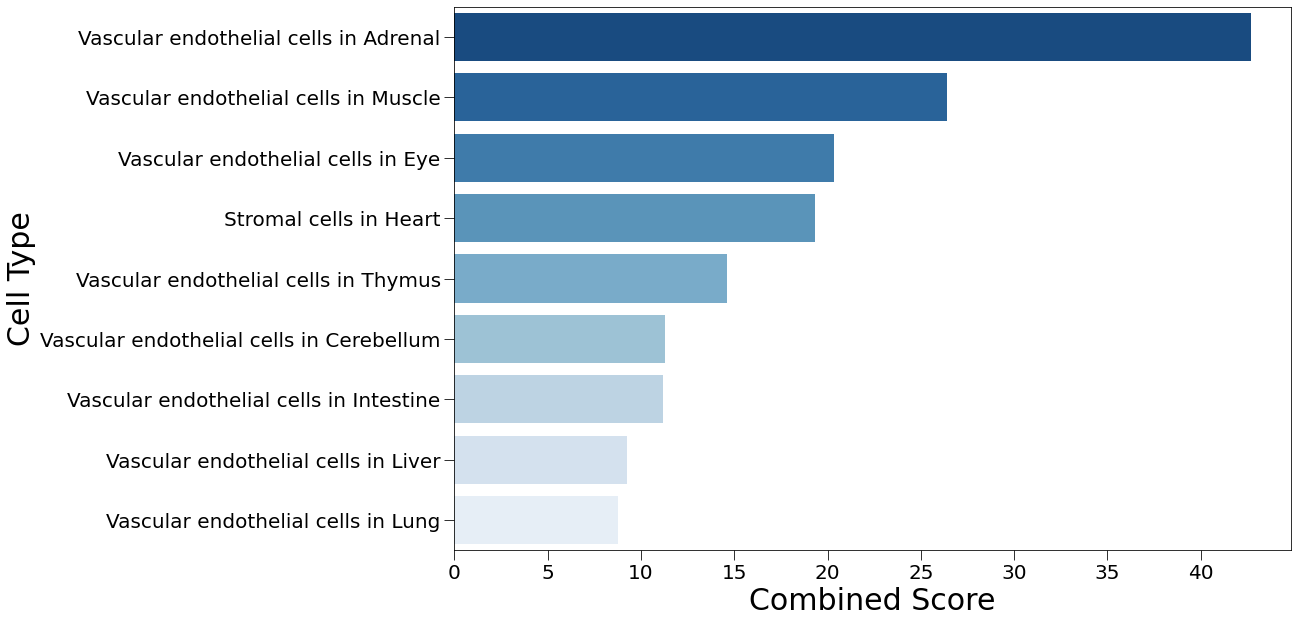

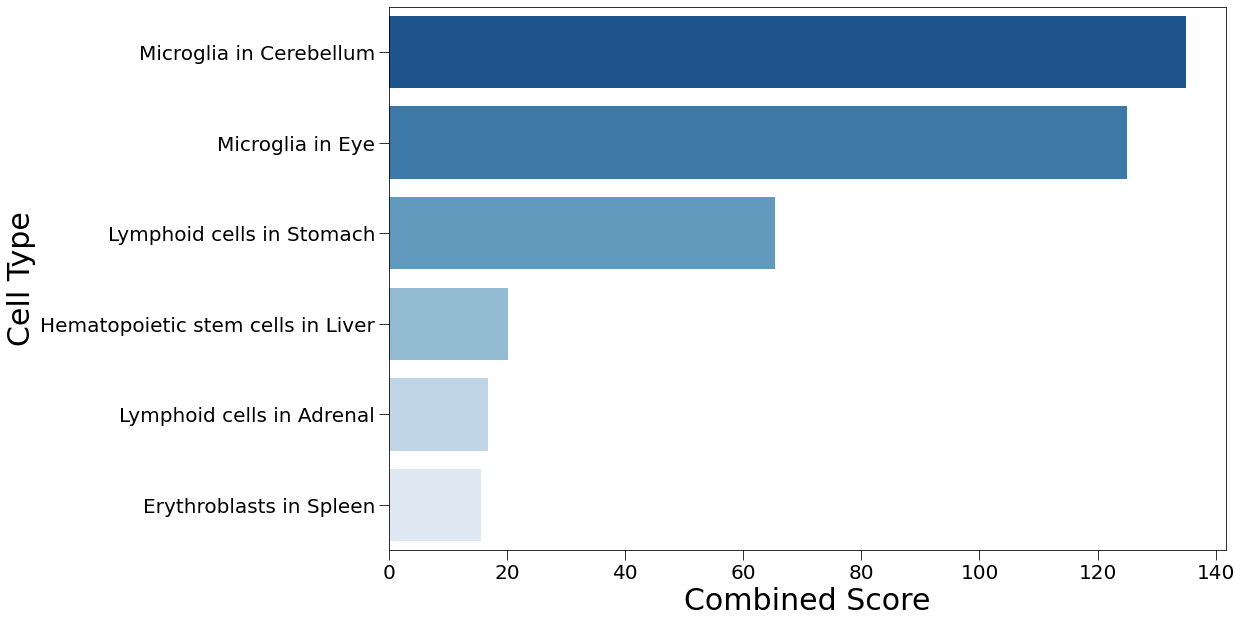

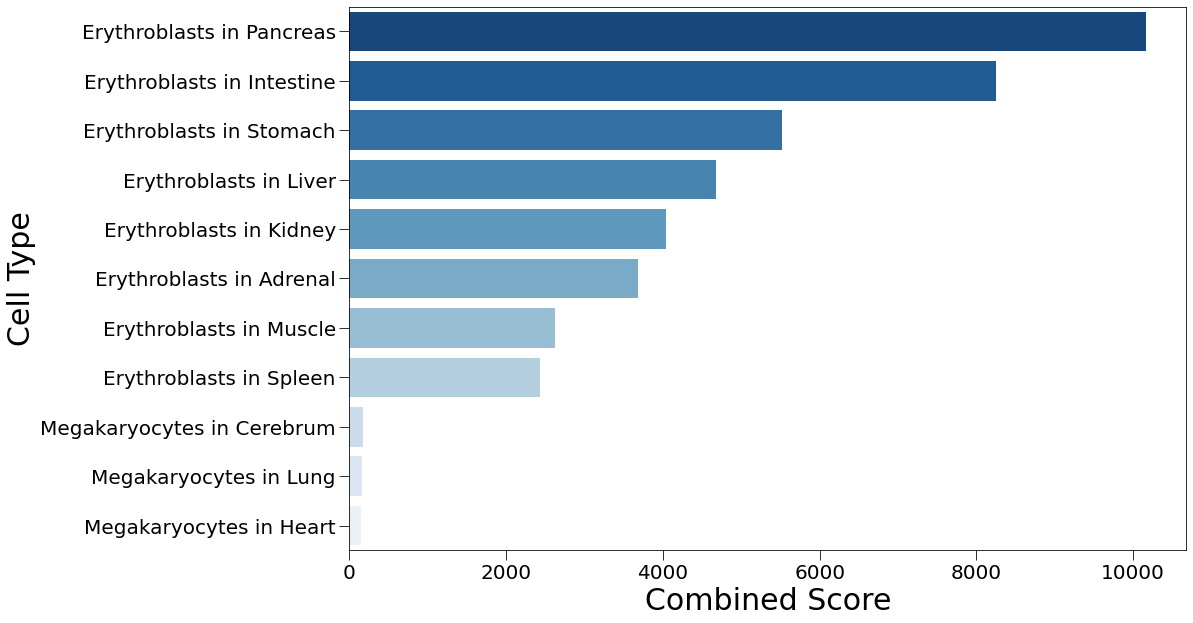

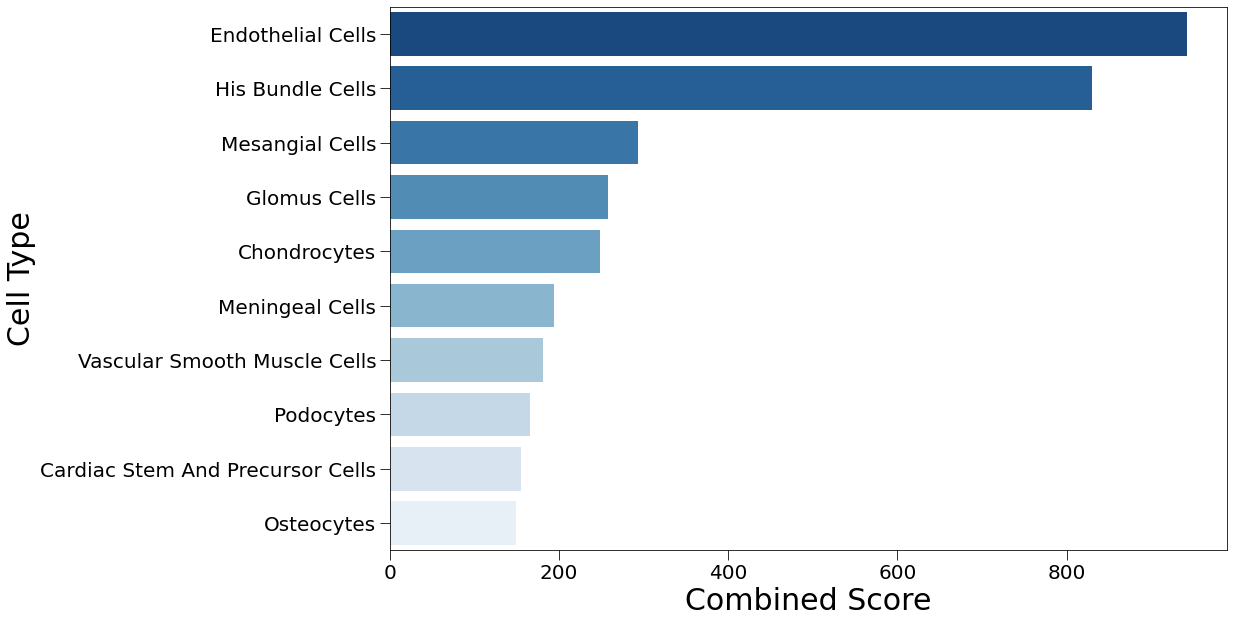

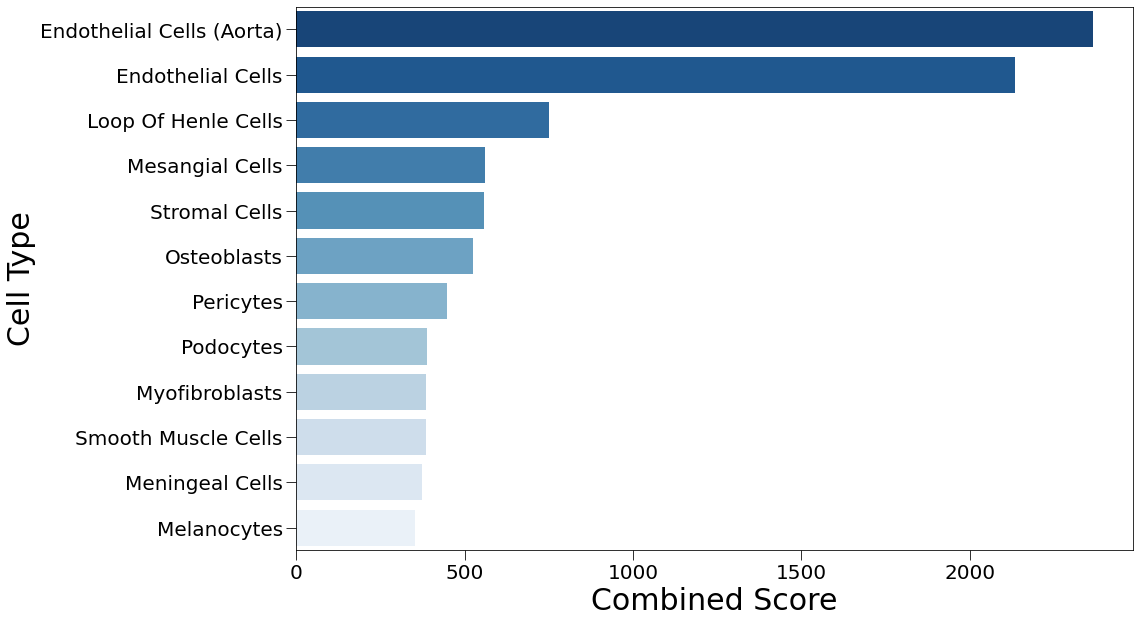

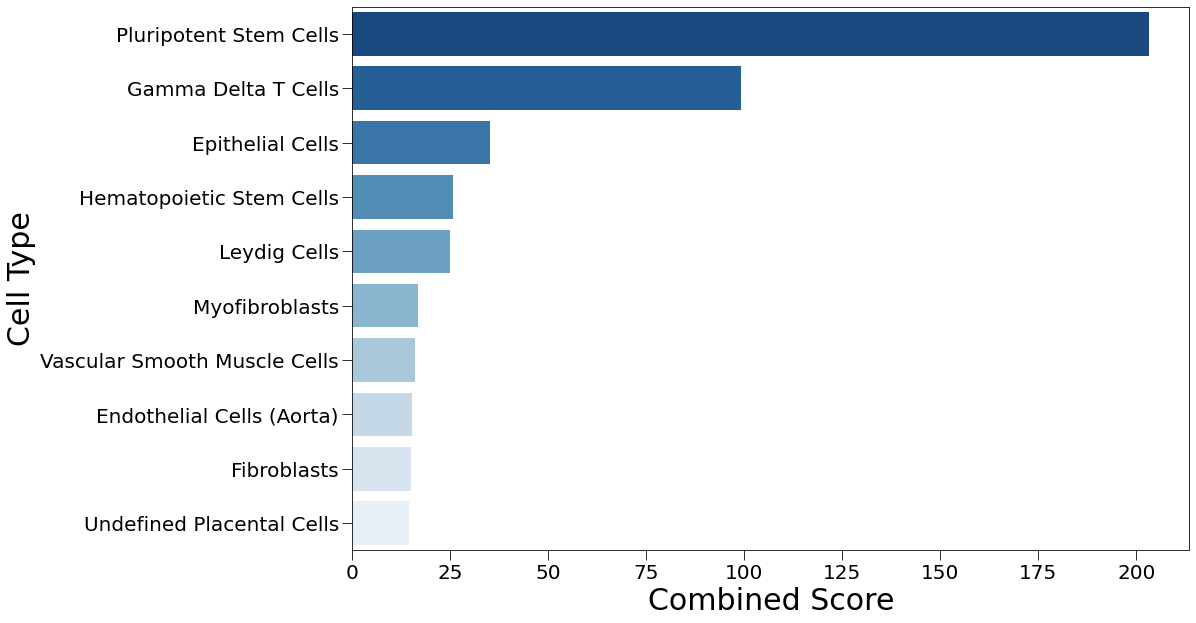

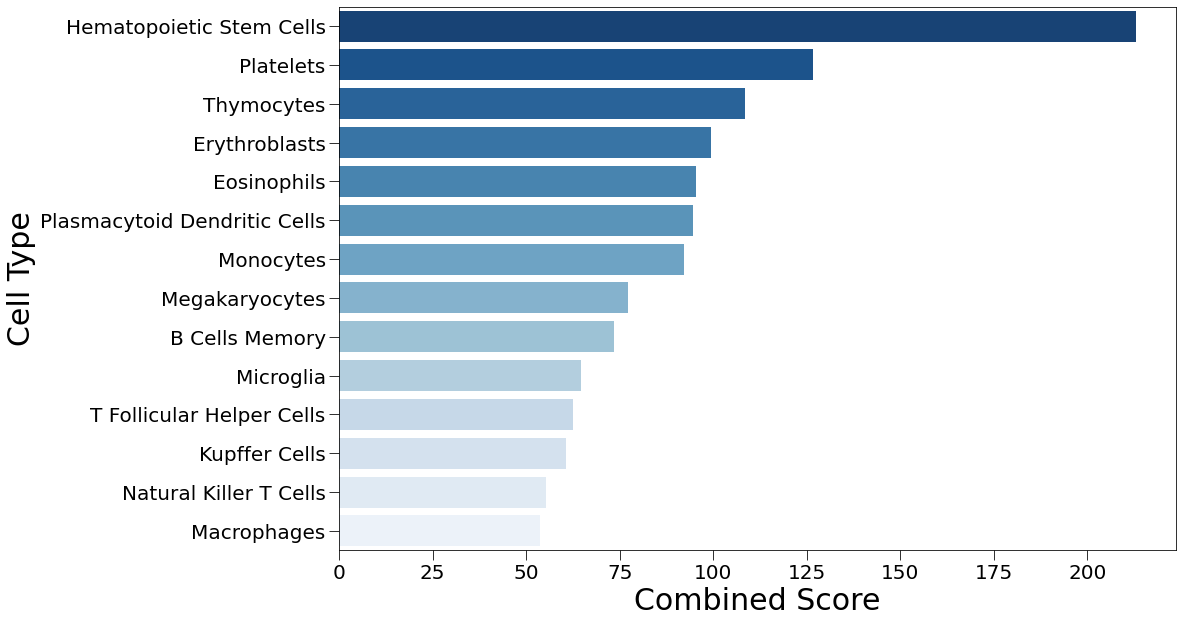

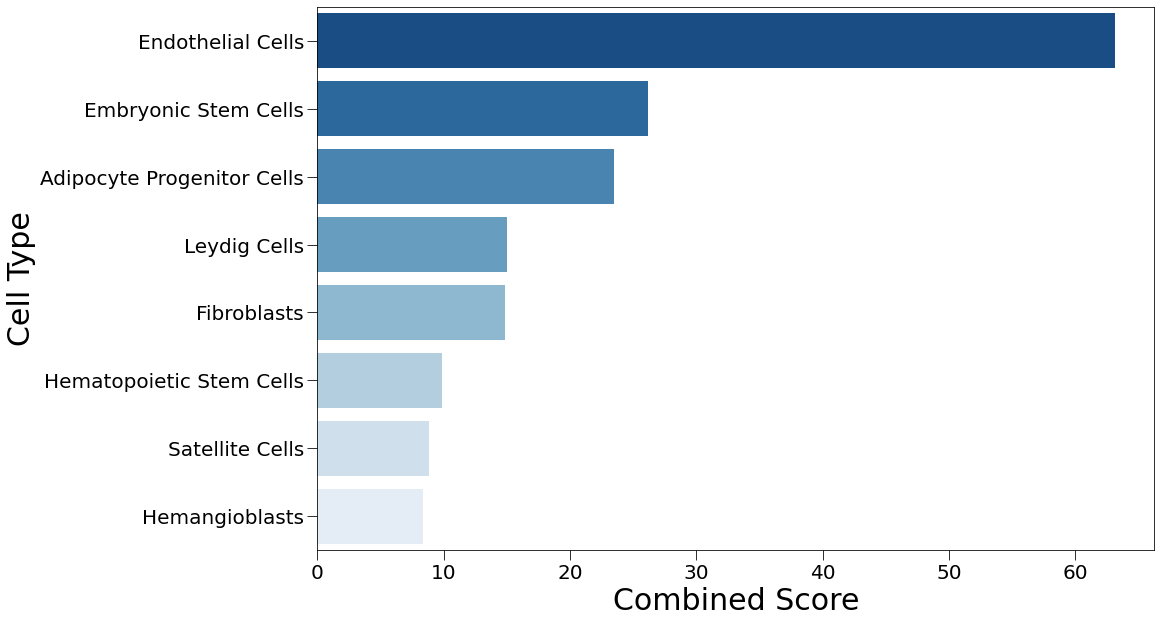

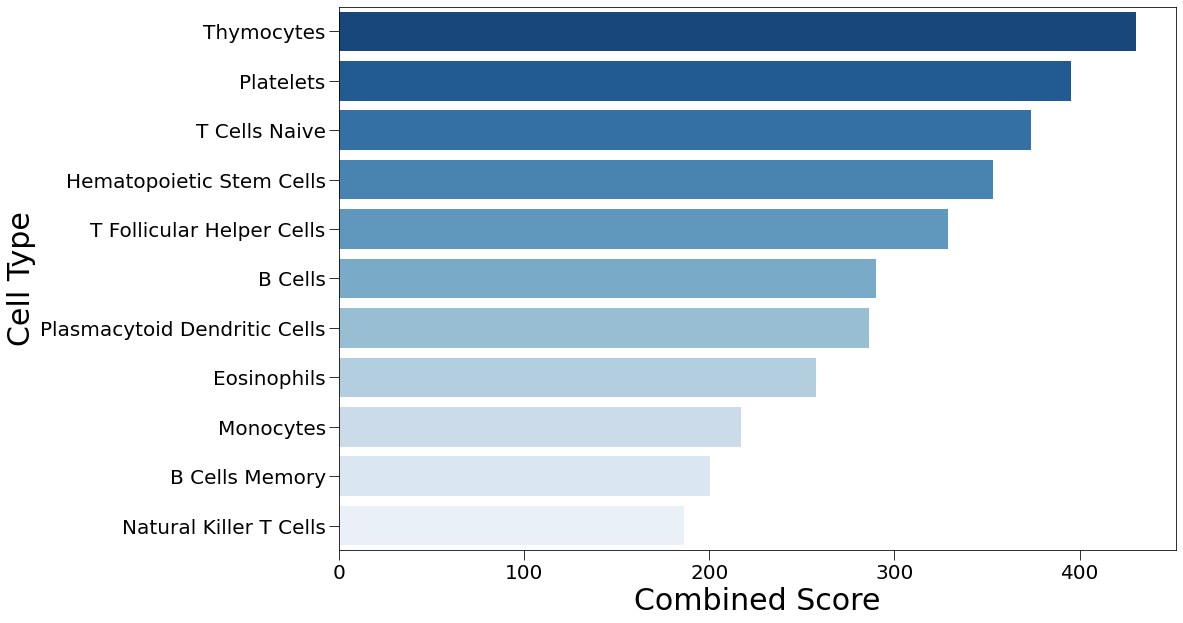

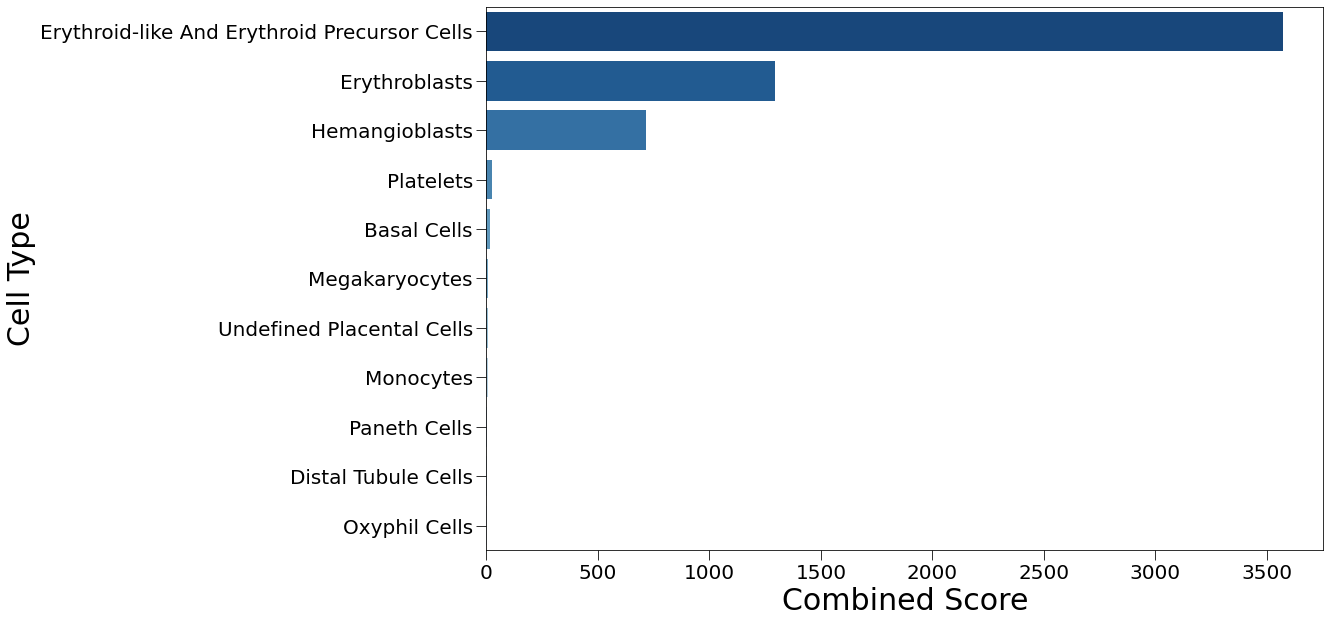

In [19]:
for library in ENRICHR_LIBRARIES:
    for sheet in pd.ExcelFile("Tables/Fadullah1_Enrich_"+library+".xlsx").sheet_names:
        data = pd.read_excel("Tables/Fadullah1_Enrich_"+library+".xlsx",sheet_name=sheet)
        data.sort_values("Combined Score",ascending=False,inplace=True)
        
        fig,ax=plt.subplots(figsize=[15,10])
        sns.barplot(data = data.loc[:10,:],x="Combined Score",y="Name",palette="Blues_r",ax=ax)
        sctplot.plot_base(ax,labels=["Combined Score","Cell Type"],legend=False)
        
        fig.savefig("Plots/Fadlullah1_"+library+"_"+sheet+".pdf",transparent=True,bbox_inches="tight")

# Fig 2: E10.5 data

In [20]:
adata.X = adata.layers["Raw"].copy()
adata = adata[adata.obs["Stage"]=="E10.5"]

In [21]:
scp.pp.normalize_total(adata,target_sum=np.mean(adata.obs["#counts"].values))
scp.pp.log1p(adata)
scp.pp.highly_variable_genes(adata)
scp.pp.pca(adata,n_comps=20)
scp.pp.neighbors(adata,metric="correlation",knn=15)
scp.tl.umap(adata)

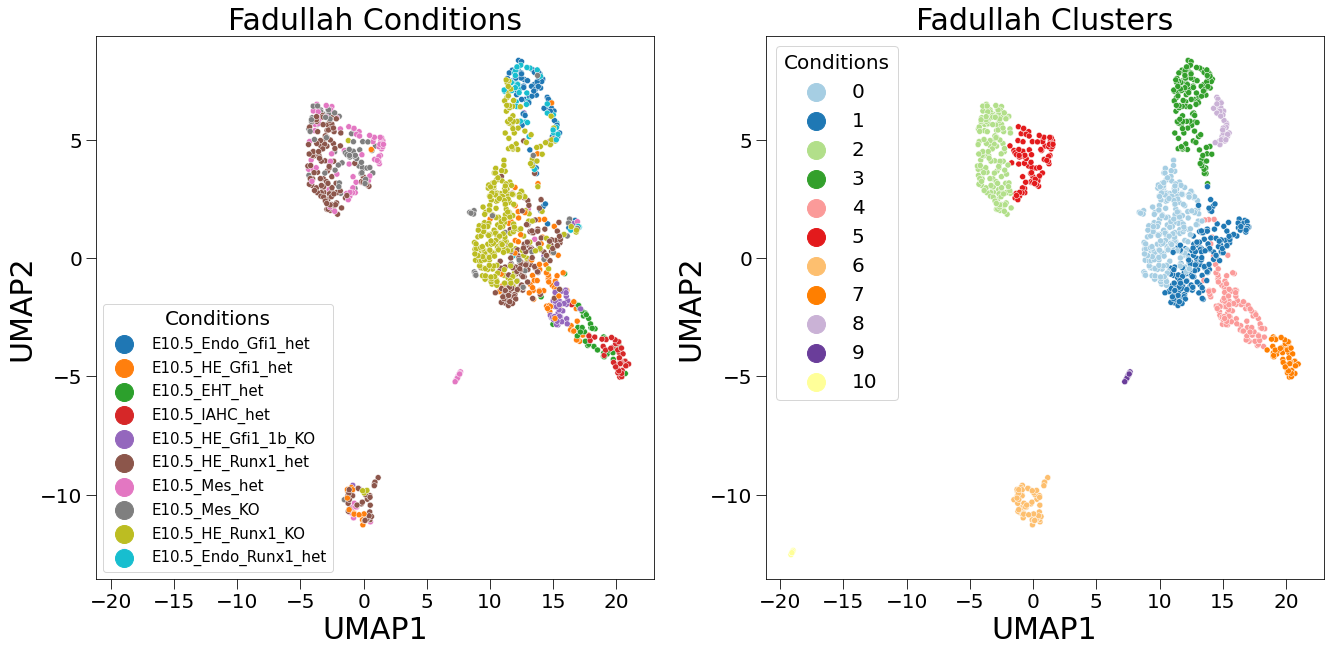

In [22]:
fig,ax = plt.subplots(1,2,figsize=[22,10])

scp.tl.leiden(adata,resolution=.5)

X = adata.obsm["X_umap"]
hue = [i+"_"+j for i,j in adata.obs[["Stage","Sorted"]].values]
sns.scatterplot(x=X[:,0],y=X[:,1],hue=hue,ax=ax[0])
sctplot.plot_base(ax[0],labels=["UMAP1","UMAP2"],title="Fadullah Conditions",legend_title="Conditions",legend_size=15,legend_markerscale=3)

X = adata.obsm["X_umap"]
hue = adata.obs["leiden"].values
sns.scatterplot(x=X[:,0],y=X[:,1],hue=hue,ax=ax[1],palette ="Paired")
sctplot.plot_base(ax[1],labels=["UMAP1","UMAP2"],title="Fadullah Clusters",legend_title="Conditions",legend_size=20,legend_markerscale=3)

fig.savefig("Plots/Fadlullah2_umaps.pdf",bbox_inches="tight",transparent=True)
plt.show()

In [23]:
adata.write("Fadlullah2.h5ad")

... storing 'Genotype' as categorical
... storing 'Stage' as categorical
... storing 'Sorted' as categorical
... storing 'gene_name' as categorical


## DE

In [24]:
scp.tl.rank_genes_groups(adata,groupby="leiden",method="wilcoxon",use_raw=False)
scttools.rank_genes_to_excel(adata,"gene_name","Tables/Fadullah2_annotation.xlsx",2000)

## Enrichr

In [25]:
ENRICHR_LIBRARIES = ["Descartes_Cell_Types_and_Tissue_2021","PanglaoDB_Augmented_2021"]

In [26]:
for library in ENRICHR_LIBRARIES:
    scttools.enrichr_to_excel(adata,library,"Tables/Fadullah2_Enrich_"+library+".xlsx")

In [ ]:
for library in ENRICHR_LIBRARIES:
    for sheet in pd.ExcelFile("Tables/Fadullah2_Enrich_"+library+".xlsx").sheet_names:
        data = pd.read_excel("Tables/Fadullah2_Enrich_"+library+".xlsx",sheet_name=sheet)
        data.sort_values("Combined Score",ascending=False,inplace=True)
        
        fig,ax=plt.subplots(figsize=[15,10])
        sns.barplot(data = data.loc[:10,:],x="Combined Score",y="Name",palette="Blues_r",ax=ax)
        sctplot.plot_base(ax,labels=["Combined Score","Cell Type"],legend=False)
        
        fig.savefig("Plots/Fadlullah2_"+library+"_"+sheet+".pdf",transparent=True,bbox_inches="tight")